<a href="https://colab.research.google.com/github/FrancescaTorazzi/jellyfish_classification-/blob/main/DeepLearningProject_finale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from d2l import torch as d2l

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#this get access to drive

Mounted at /content/drive


In [ ]:
zip_path = "/content/drive/MyDrive/JellyfishDataset/archive.zip" #path for Drive

In [ ]:
!pip install d2l

In [ ]:

import os, csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import shutil
import random
from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import random_split, DataLoader
from torch.nn import functional as F
from tqdm import tqdm
import torch.optim as optim
from d2l import torch as d2l
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

**Comparative Analysis of Jellyfish Classification using GoogleNet and ResNet**

This project explores the automatic classification of jellyfish species by primarily utilizing GoogleNet. To evaluate its performance, ResNet was also employed as a benchmark for comparison. The dataset consists of 900 uniformly square images (ranging from 179×179 to 224×224 pixels) evenly distributed among six species, with 150 images per class. The species are described as follows:

- **Blue Jellyfish:** Striking blue hue and graceful form, typical of tropical waters.
- **Barrel Jellyfish:** Robust, barrel-shaped bell paired with prominent tentacles.
- **Compass Jellyfish:** Notable for its unique, compass-like patterns.
- **Mauve Stinger Jellyfish:** Distinguished by its soft mauve bell and potentially painful sting.
- **Moon Jellyfish:** Exhibits a translucent, moon-like appearance with delicate tentacles.
- **Lion’s Mane Jellyfish:** Characterized by its impressive size and long, flowing tentacles reminiscent of a lion’s mane.

The analysis focuses on evaluating the classification performance of GoogleNet and comparing the results with those obtained from ResNet, highlighting the strengths and differences of each model.


In [ ]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/JellyfishDataset/archive.zip"  # <-- Verifica il percorso corretto
extract_path = "/content/dataset"  # Dove estrarre i file

# Estrazione dello ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("File extracted in:", extract_path)


File extracted in: /content/dataset


In [ ]:
print(os.listdir(extract_path))

['lions_mane_jellyfish', 'barrel_jellyfish', 'mauve_stinger_jellyfish', 'Moon_jellyfish', 'Train_Test_Valid', 'blue_jellyfish', 'compass_jellyfish']


This script extracts the zip archive from the specified Google Drive path into a local directory and prints the extraction path.

**Elimination of "Trail_valid_test"**

The “Train_Test_Valid” directory was removed because it already contained a pre-split dataset. Since the dataset will be randomly divided into training, validation, and test sets later in the process, the pre-existing split was unnecessary.

In [ ]:
import shutil

#Path for removing Train_Test_Valid
remove_path = os.path.join(extract_path, "Train_Test_Valid")

# Verify if Train_Test_Valid has been correctely removed
if os.path.exists(remove_path):
    shutil.rmtree(remove_path)
    print(" 'Train_Test_Valid' succesfully removed!")
else:
    print("'Train_Test_Valid' was not present.")

 'Train_Test_Valid' succesfully removed!


In [ ]:
from collections import Counter

# Number of images per species
data_dirs = [d for d in os.listdir(extract_path) if os.path.isdir(os.path.join(extract_path, d))]
file_counts = {d: len(os.listdir(os.path.join(extract_path, d))) for d in data_dirs}

print("Number of images for species:")
print(file_counts)

Number of images for species:
{'lions_mane_jellyfish': 150, 'barrel_jellyfish': 150, 'mauve_stinger_jellyfish': 150, 'Moon_jellyfish': 150, 'blue_jellyfish': 150, 'compass_jellyfish': 150}


**Dataset Description**

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

dataset_path = "/content/dataset"
data = []

for root, _, files in os.walk(dataset_path):
    for image_name in files:
        if image_name.lower().endswith(('.jpg', '.png', '.jpeg')):
            image_path = os.path.join(root, image_name)
            with Image.open(image_path) as img:
                width, height = img.size
                aspect = width / height
                data.append({'width': width, 'height': height, 'aspect_ratio': aspect})

df = pd.DataFrame(data)
print(df.describe())


            width      height  aspect_ratio
count  900.000000  900.000000         900.0
mean   210.600000  210.600000           1.0
std     20.589099   20.589099           0.0
min    179.000000  179.000000           1.0
25%    179.000000  179.000000           1.0
50%    224.000000  224.000000           1.0
75%    224.000000  224.000000           1.0
max    224.000000  224.000000           1.0


**Dataset description**:

- **Total Images:** The dataset consists of 900 images.
- **Uniform Aspect Ratio:** The `aspect_ratio` is consistently 1.0 for all images, which means every image is square (width equals height).
- **Dimensions Distribution:**  
  - The minimum image size is 179×179 pixels, and the maximum is 224×224 pixels.  
  - The mean dimensions are approximately 210.6×210.6 pixels, with a standard deviation of about 20.59 pixels.  


The dataset is homogeneous in terms of size and shape therefore variability in image dimensions or aspect ratios is low.


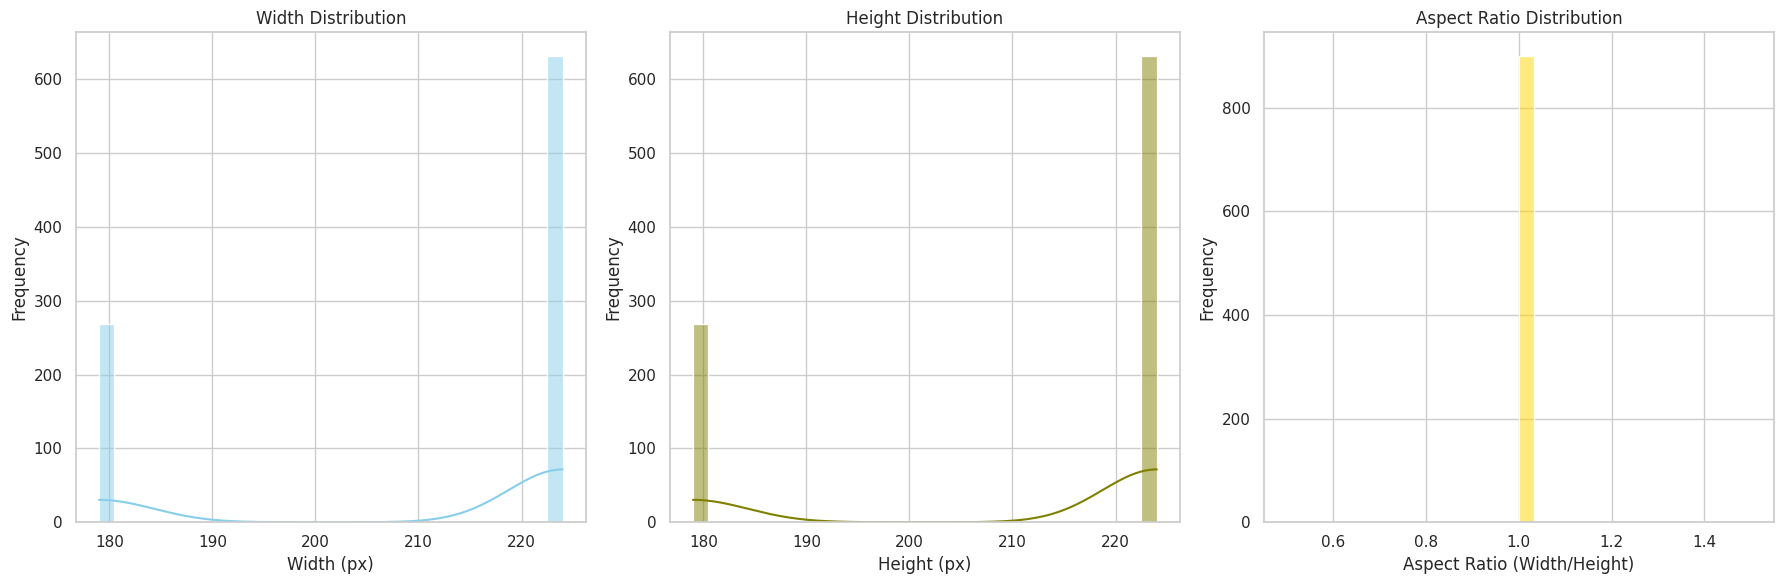

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
plt.figure(figsize=(18, 6))

# Histogram for Widths
plt.subplot(1, 3, 1)
sns.histplot(df['width'], bins=30, kde=True, color="skyblue")
plt.title('Width Distribution')
plt.xlabel('Width (px)')
plt.ylabel('Frequency')

# Histogram for Heights
plt.subplot(1, 3, 2)
sns.histplot(df['height'], bins=30, kde=True, color="olive")
plt.title('Height Distribution')
plt.xlabel('Height (px)')
plt.ylabel('Frequency')

# Histogram for Aspect Ratios
plt.subplot(1, 3, 3)
sns.histplot(df['aspect_ratio'], bins=30, kde=True, color="gold")
plt.title('Aspect Ratio Distribution')
plt.xlabel('Aspect Ratio (Width/Height)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



**Width Distribution**  
This histogram shows that the images in the dataset have two dominant width values: 179 px and 224 px. The bars indicate a bimodal distribution, where a subset of images is clustered around 179 px, while another large group is around 224 px.

**Height Distribution**  
Similarly, the height histogram reveals the same pattern: most images are either 179 px or 224 px in height. This mirrors the width distribution and further confirms that the dataset primarily contains images of two distinct sizes.

**Aspect Ratio Distribution**  
All images have an aspect ratio of exactly 1.0, meaning they are square. The single, tall bar at 1.0 indicates there is no variation in width-to-height ratio across the dataset.

In summary two clear clusters appear at (179, 179) and (224, 224). This indicates that the dataset comprises square images of these two specific dimensions, reinforcing the observations from the histograms.

Label counts: {'lions_mane_jellyfish': 150, 'barrel_jellyfish': 150, 'mauve_stinger_jellyfish': 150, 'Moon_jellyfish': 150, 'blue_jellyfish': 150, 'compass_jellyfish': 150}


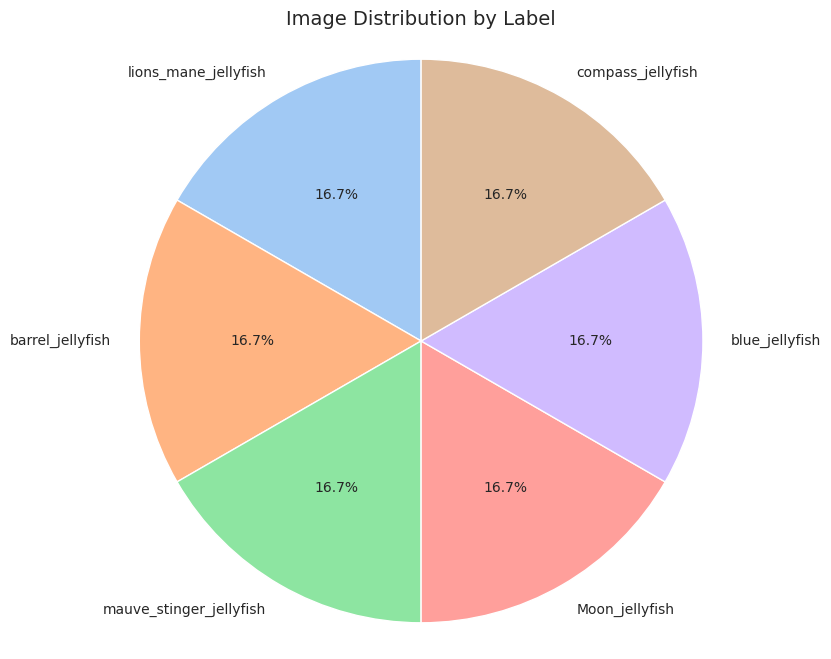

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Path to your dataset
dataset_path = "/content/dataset"

# Dictionary to count images per label
label_counts = {}

for label in os.listdir(dataset_path):
    label_path = os.path.join(dataset_path, label)
    # Exclude the 'Train_Test_Valid' folder and only consider directories
    if os.path.isdir(label_path) and label != 'Train_Test_Valid':
        # Count how many image files are in this folder (not recursively)
        num_images = len([f for f in os.listdir(label_path)
                          if f.lower().endswith(('.jpg', '.png', '.jpeg'))])
        label_counts[label] = num_images

# Check if there are any labels
if not label_counts:
    raise ValueError("No labels found in the dataset path.")

# Print out the counts for debugging
print("Label counts:", label_counts)

# --- PLOT SETTINGS ---
# We'll use Seaborn's 'pastel' palette for a nicer look
sns.set_style("whitegrid")
colors = sns.color_palette("pastel", len(label_counts))

plt.figure(figsize=(8, 8))
# Create the pie chart
wedges, texts, autotexts = plt.pie(
    label_counts.values(),
    labels=label_counts.keys(),
    autopct='%1.1f%%',
    startangle=90,
    colors=colors
)

# Make the text more readable
for text in texts:
    text.set_fontsize(10)
for autotext in autotexts:
    autotext.set_fontsize(10)

plt.title('Image Distribution by Label', fontsize=14)
plt.axis('equal')

plt.show()


**Pie chart**

The image above shows a pie chart representing the distribution of images by label within the dataset. Each slice of the chart corresponds to a jellyfish category.  
The indicated percentages (16.7% for each class) suggest that the images are evenly distributed among the categories.

**Random Sample Visualization from Each Category**

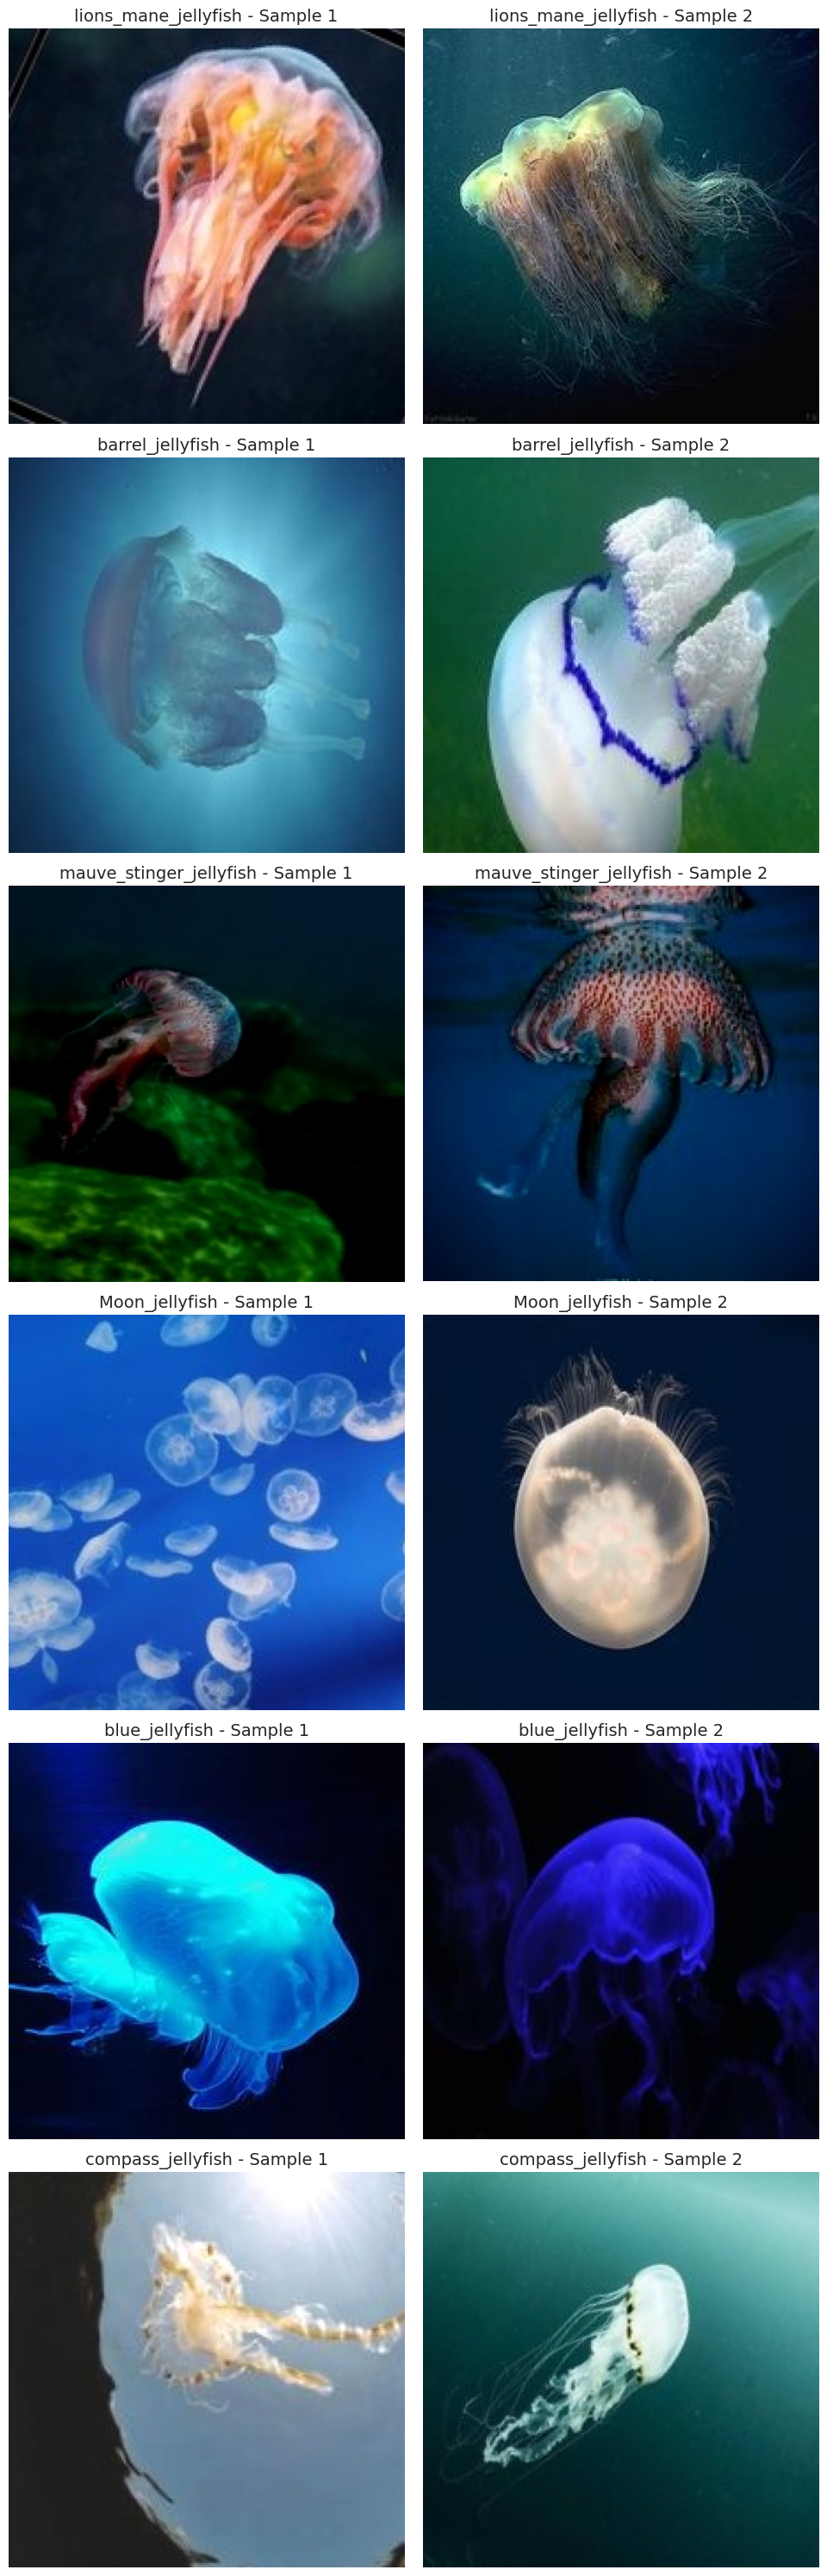

In [ ]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Specify the path to your dataset
dataset_path = "/content/dataset"

# Create a dictionary mapping each category (subfolder) to its list of image files
category_to_images = {}

for label in os.listdir(dataset_path):
    label_path = os.path.join(dataset_path, label)
    # Check if it's a directory
    if os.path.isdir(label_path):
        # Gather all image files in this directory (non-recursive)
        category_to_images[label] = [
            file for file in os.listdir(label_path)
            if file.lower().endswith(('.jpg', '.png', '.jpeg'))
        ]

# Raise an error if no categories are found
if not category_to_images:
    raise ValueError("No categories found in the dataset path.")

# Set a random seed for reproducibility
random.seed(123)

# For each category, select 2 random images (if available)
random_images = {}
for category, images in category_to_images.items():
    if len(images) >= 2:
        random_images[category] = random.sample(images, 2)
    elif images:
        random_images[category] = images  # If only one image is available, use it

# Determine the number of categories
num_categories = len(random_images)

# Create a subplot grid with each row representing a category and 2 columns for the two samples
fig, axes = plt.subplots(num_categories, 2, figsize=(10, 5 * num_categories))

# If there's only one category, ensure axes is a 2D array
if num_categories == 1:
    axes = [axes]

# Display the images for each category
for row_idx, (category, image_names) in enumerate(random_images.items()):
    for col_idx in range(2):
        ax = axes[row_idx][col_idx] if num_categories > 1 else axes[col_idx]
        if col_idx < len(image_names):
            image_path = os.path.join(dataset_path, category, image_names[col_idx])
            try:
                with Image.open(image_path) as img:
                    ax.imshow(img)
                    ax.set_title(f"{category} - Sample {col_idx + 1}", fontsize=14)
            except Exception as e:
                ax.text(0.5, 0.5, f"Error loading image:\n{e}", ha='center', va='center')
        else:
            # Hide the subplot if there isn't a second image
            ax.axis('off')
        ax.axis('off')  # Hide axes for a cleaner look

plt.tight_layout()
plt.show()


This script selects two random images from each category within a dataset, then displays them side by side in a grid format for easy visual comparison.

**Loading of the dataset**

**The code below is responsible for loading an image dataset, splitting it into training, validation, and test sets, computing normalization statistics, and applying data augmentation to enhance model generalization.**
1. *Computing Mean and Standard Deviation*:

  Before normalizing the images, the code calculates the mean and standard deviation of the RGB channels across the training set.
  This helps in ensuring that the data distribution is centered around zero, improving model convergence.
2. *Dataset Splitting*:

  The dataset is divided into three subsets:
  Training set (70%): Used to train the model.
  Validation set (20%): Used to tune hyperparameters and prevent overfitting.
  Test set (10%): Used to evaluate final model performance.
  The split ensures that data is properly allocated for effective model training and evaluation.
3. *Data Augmentation*:

  Data augmentation is applied only to the training set to increase dataset diversity and improve model generalization.
  The transformations include:
  - Random Horizontal Flip: Introduces variations by flipping images.
  - Random Rotation: Rotates images within a defined range.
  - Random Resized Crop: Crops and resizes images dynamically.
  - Color Jittering: Adjusts brightness, contrast, saturation, and hue.
  - Gaussian Blur: Slightly blurs images to simulate real-world variations.

  These techniques help prevent overfitting and improve the model's ability to generalize to unseen data.
4. *Data Loading with PyTorch DataLoader*:

  The DataLoader efficiently loads images in batches, improving computational efficiency.
  It uses multiple CPU workers to speed up data retrieval.
  The training loader shuffles data to ensure a varied input sequence during training.
5. *Final Outputs*:

   The model can now be trained on an augmented dataset.

In [ ]:
from torchvision import datasets, transforms
import torch
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader, random_split
import os

# Funzione per calcolare la media e la deviazione standard solo sul training set
def calculate_mean_std(dataset):
    mean = torch.zeros(3)
    std = torch.zeros(3)
    total_images = len(dataset)

    for img, _ in tqdm(dataset):
        mean += img.mean(dim=[1, 2])
        std += img.std(dim=[1, 2])

    mean /= total_images
    std /= total_images
    return mean, std

# Funzione per ottenere il numero di workers per il DataLoader
def get_dataloader_workers():
    return os.cpu_count()

# Funzione per caricare il dataset e creare DataLoaders
def data_loader(dataset_path,
                batch_size,
                height, width,
                augmentation=False,
                train_perc=0.7, val_perc=0.2,
                seed=123):

    # Set seeds per la riproducibilità
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Carica il dataset senza normalizzazione per calcolare la media e std
    temp_transform = transforms.Compose([
        transforms.Resize((height, width)),
        transforms.ToTensor()
    ])
    temp_dataset = datasets.ImageFolder(root=dataset_path, transform=temp_transform)

    # Suddivisione per ottenere il training set (solo per calcolare mean/std)
    dataset_size = len(temp_dataset)
    train_size = int(train_perc * dataset_size)
    val_size = int(val_perc * dataset_size)
    test_size = dataset_size - train_size - val_size

    train_dataset, _, _ = random_split(temp_dataset, [train_size, val_size, test_size])

    # Calcola mean e std solo sul training set
    mean, std = calculate_mean_std(train_dataset)
    print(f"Calculated Mean: {mean.tolist()}")
    print(f"Calculated Std: {std.tolist()}")

    # Trasformazione base con normalizzazione
    base_transform = transforms.Compose([
        transforms.Resize((height, width)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

    # Trasformazione con augmentation solo per il training set
    augmentation_transform = transforms.Compose([
        transforms.Resize((height, width)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=20),
        transforms.RandomResizedCrop(size=height, scale=(0.8, 1.0)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))], p=0.3),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

    # Carica il dataset completo con trasformazione base
    full_dataset = datasets.ImageFolder(root=dataset_path, transform=base_transform)

    # Suddivisione del dataset
    train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

    # Se augmentation è attivata, applicala solo al training set
    if augmentation:
        train_dataset.dataset.transform = augmentation_transform

    # Creazione dei DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=get_dataloader_workers())
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=get_dataloader_workers())
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=get_dataloader_workers())

    return full_dataset, train_loader, val_loader, test_loader, mean, std

# Parametri
dataset_path = "/content/dataset"
batch_size = 64
height, width = 224, 224

# Carica il dataset
full_dataset, train_loader, val_loader, test_loader, mean, std = data_loader(
    dataset_path=dataset_path,
    batch_size=batch_size,
    height=height,
    width=width,
    augmentation=True
)

# Stampa dimensioni dei dataset
print(f'Total dataset size: {len(full_dataset)}')
print(f'Train set size: {len(train_loader.dataset)}')
print(f'Validation set size: {len(val_loader.dataset)}')
print(f'Test set size: {len(test_loader.dataset)}')


100%|██████████| 630/630 [00:01<00:00, 383.93it/s]

Calculated Mean: [0.2624128460884094, 0.3614979386329651, 0.4185490310192108]
Calculated Std: [0.19481545686721802, 0.1777471899986267, 0.1962539255619049]
Total dataset size: 900
Train set size: 630
Validation set size: 180
Test set size: 90


**Visualization of a batch**



- **Batch Representation:**  
  The batch is a tensor of shape `(batch_size, channels, height, width)` extracted from the training DataLoader. It represents a group of images that are processed simultaneously during model training.
---

Train set size: 630
Validation set size: 180
Test set size: 90


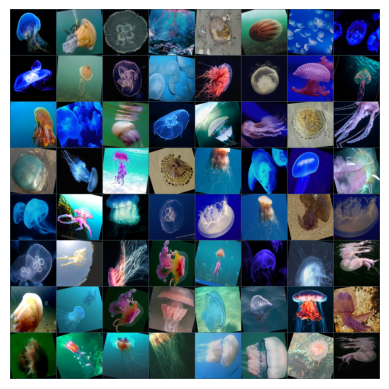

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torchvision.utils import make_grid

# Function to denormalize and display an image tensor
def imshow(img, mean, std):
    """
    Denormalize and display an image tensor.

    Args:
        img (Tensor): Image tensor of shape (C, H, W)
        mean (list): List of mean values for each channel
        std (list): List of standard deviation values for each channel
    """
    # Clone the tensor to avoid modifying the original image
    img_denorm = img.clone()

    # Denormalize each channel: reverse the normalization transformation
    for i in range(3):  # Assuming 3 channels (RGB)
        img_denorm[i] = img_denorm[i] * std[i] + mean[i]

    # Convert tensor to numpy array and transpose dimensions for display
    npimg = img_denorm.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')  # Hide axis for a cleaner look
    plt.show()

# Print dataset sizes for confirmation
print(f'Train set size: {len(train_loader.dataset)}')
print(f'Validation set size: {len(val_loader.dataset)}')
print(f'Test set size: {len(test_loader.dataset)}')

# Get a batch of images from the training DataLoader
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Create a grid of images and display it
grid = make_grid(images)
imshow(grid, mean, std)


**Inceptions**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Inception(nn.Module):
    def __init__(self, input_channels, c1, c2, c3, c4):
        super(Inception, self).__init__()

        self.path1 = nn.Sequential(
            nn.Conv2d(input_channels, c1, kernel_size=1),
            nn.BatchNorm2d(c1),
        )

        # Path 2: 1x1 -> 3x3 Convolution
        self.path2_1 = nn.Sequential(
            nn.Conv2d(input_channels, c2[0], kernel_size=1),
            nn.BatchNorm2d(c2[0]),
        )
        self.path2_2 = nn.Sequential(
            nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1),
            nn.BatchNorm2d(c2[1]),
        )

        # Path 3: 1x1 -> 5x5 Convolution
        self.path3_1 = nn.Sequential(
            nn.Conv2d(input_channels, c3[0], kernel_size=1),
            nn.BatchNorm2d(c3[0]),
        )
        self.path3_2 = nn.Sequential(
            nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2),
            nn.BatchNorm2d(c3[1]),
        )

        # Path 4: Max Pooling -> 1x1 Convolution
        self.path4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.path4_2 = nn.Sequential(
            nn.Conv2d(input_channels, c4, kernel_size=1),
            nn.BatchNorm2d(c4),
        )

    def forward(self, x):
        p1 = F.leaky_relu(self.path1(x))
        p2 = F.leaky_relu(self.path2_2(self.path2_1(x)))
        p3 = F.leaky_relu(self.path3_2(self.path3_1(x)))
        p4 = F.leaky_relu(self.path4_2(self.path4_1(x)))
        output = torch.cat((p1, p2, p3, p4), dim=1)
        return output


The steps implemented in the Inception module for GoogLeNet are:

1. **Branch 1 (Path1):**  
   - Applies a 1x1 convolution to reduce dimensionality.  
   - Follows up with batch normalization.  
   - Uses ReLU as the activation function on the output.

2. **Branch 2 (Path2):**  
   - Starts with a 1x1 convolution to reduce dimensionality, followed by batch normalization.  
   - Then applies a 3x3 convolution (with padding=1 to preserve spatial dimensions) and batch normalization.  
   - The output is passed through ReLU.

3. **Branch 3 (Path3):**  
   - Begins with a 1x1 convolution to reduce the number of channels, followed by batch normalization.  
   - A 5x5 convolution (with padding=2 for spatial consistency) is applied next, along with batch normalization.  
   - The branch output is activated using ReLU.

4. **Branch 4 (Path4):**  
   - Utilizes a 3x3 max pooling operation (with stride=1 and padding=1) to capture local features.  
   - Applies a 1x1 convolution and batch normalization to the pooled output.  
   - The resulting features are activated with ReLU.

5. **Concatenation:**  
   - The outputs from all four branches are concatenated along the channel dimension. This combined output forms the final result of the Inception module.

These steps ensure that each branch processes the input with different receptive fields and that the final module benefits from multi-scale feature extraction, a key aspect of GoogLeNet's architecture.

**Blocks GoogLeNet**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Definition of the Inception module using LeakyReLU activations
class Inception(nn.Module):
    def __init__(self, input_channels, c1, c2, c3, c4):
        super(Inception, self).__init__()

        # Branch 1: 1x1 Convolution
        self.path1 = nn.Sequential(
            nn.Conv2d(input_channels, c1, kernel_size=1),
            nn.BatchNorm2d(c1),
        )

        # Branch 2: 1x1 Convolution followed by 3x3 Convolution
        self.path2_1 = nn.Sequential(
            nn.Conv2d(input_channels, c2[0], kernel_size=1),
            nn.BatchNorm2d(c2[0]),
        )
        self.path2_2 = nn.Sequential(
            nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1),
            nn.BatchNorm2d(c2[1]),
        )

        # Branch 3: 1x1 Convolution followed by 5x5 Convolution
        self.path3_1 = nn.Sequential(
            nn.Conv2d(input_channels, c3[0], kernel_size=1),
            nn.BatchNorm2d(c3[0]),
        )
        self.path3_2 = nn.Sequential(
            nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2),
            nn.BatchNorm2d(c3[1]),
        )

        # Branch 4: Max Pooling followed by 1x1 Convolution
        self.path4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.path4_2 = nn.Sequential(
            nn.Conv2d(input_channels, c4, kernel_size=1),
            nn.BatchNorm2d(c4),
        )

    def forward(self, x):
        # Use LeakyReLU for all branches
        p1 = F.leaky_relu(self.path1(x))
        p2 = F.leaky_relu(self.path2_2(self.path2_1(x)))
        p3 = F.leaky_relu(self.path3_2(self.path3_1(x)))
        p4 = F.leaky_relu(self.path4_2(self.path4_1(x)))
        # Concatenate outputs along the channel dimension
        output = torch.cat((p1, p2, p3, p4), dim=1)
        return output

# Block 1: Initial convolution and pooling layers
b1 = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(),  # Using LeakyReLU activation
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    nn.Dropout(p=0.1)
)

# Block 2: Additional convolutional layers with pooling
b2 = nn.Sequential(
    nn.Conv2d(64, 64, kernel_size=1),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(),  # Using LeakyReLU activation
    nn.Conv2d(64, 192, kernel_size=3, padding=1),
    nn.BatchNorm2d(192),
    nn.LeakyReLU(),  # Using LeakyReLU activation
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    nn.Dropout(p=0.2)
)

# Block 3: Inception modules followed by pooling
b3 = nn.Sequential(
    Inception(192, 64, (96, 128), (16, 32), 32),
    Inception(256, 128, (128, 192), (32, 96), 64),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    nn.Dropout(p=0.3)
)

# Block 4: Additional Inception modules with pooling
b4 = nn.Sequential(
    Inception(480, 192, (96, 208), (16, 48), 64),
    Inception(512, 160, (112, 224), (24, 64), 64),
    Inception(512, 128, (128, 256), (24, 64), 64),
    Inception(512, 112, (144, 288), (32, 64), 64),
    Inception(528, 256, (160, 320), (32, 128), 128),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    nn.Dropout(p=0.3)
)

# Block 5: Final Inception modules, global pooling, and dropout
b5 = nn.Sequential(
    Inception(832, 256, (160, 320), (32, 128), 128),
    Inception(832, 384, (192, 384), (48, 128), 128),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Dropout(p=0.4)
)

# Complete network: Stacking all blocks followed by a fully connected layer
num_classes = 6  # Adjust according to the number of classes in your dataset
net = nn.Sequential(
    b1, b2, b3, b4, b5,
    nn.Linear(1024, num_classes)
)

# Print the network architecture
print(net)

#data augmentation riscalare l'immagine
#14.1 image augmentation
#computer vision cap 13.1


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.1, inplace=False)
  )
  (1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
  )
  (2): Sequential(
    (0): Inception(
      (path1): Sequential(
        (0): Conv2d(192, 64, kern


**Network Architecture Explanation**

The implemented network relies on the GoogLeNet architecture and is composed of 5 blocks that progressively extract and refine features from the input images. Key components include:

- **Inception Module:**  
  The core building block is the Inception module, which processes the input through four parallel paths:
  1. **Path 1:** A 1×1 convolution reduces dimensionality, followed by batch normalization and a ReLU activation.
  2. **Path 2:** Begins with a 1×1 convolution (and batch normalization) to reduce dimensions, followed by a 3×3 convolution (with padding to preserve spatial size) and another batch normalization, with ReLU applied at the end.
  3. **Path 3:** Similar to path 2, but uses a 5×5 convolution (with padding) after an initial 1×1 convolution, batch normalization, and a ReLU activation.
  4. **Path 4:** Applies a 3×3 max pooling (with stride 1 and padding) followed by a 1×1 convolution and batch normalization, with the output activated by ReLU.
  
  The outputs from these four branches are concatenated along the channel dimension, allowing the module to capture features at multiple scales.

- **Overall Network Blocks:**  
  The network is organized into five main blocks:
  - **Block 1:** Performs an initial feature extraction using a 7×7 convolution, batch normalization, ReLU activation, max pooling, and dropout. This block reduces the spatial dimensions while increasing the number of feature channels.
  - **Block 2:** Contains additional convolutional layers with ReLU activations and pooling, further refining the feature maps.
  - **Block 3 & Block 4:** These blocks consist of multiple Inception modules. They progressively extract more complex and abstract features while reducing spatial dimensions using pooling and applying dropout for regularization.
  - **Block 5:** The final block uses adaptive average pooling to aggregate features globally, followed by flattening and dropout before passing the output to a fully connected layer.

- **Final Classification:**  
  The last layer is a linear (fully connected) layer that maps the flattened feature vector to the desired number of classes (6 in this case).

The code below tests the forward pass through the layers of the network by feeding a randomly generated input tensor 𝑋 of shape (1, 3, 224, 224), which simulates a single RGB image resized to 224×224 pixels.
The loop iterates over each layer of the network (net), processes the input through the layer, and prints the layer's class name along with the shape of its output.

It helps verify how the spatial dimensions and channel sizes evolve as the data flows through the network. Useful for debugging or ensuring the network architecture behaves as expected.

In [ ]:
X = torch.rand(size=(1, 3, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape' ,X.shape)

Sequential output shape torch.Size([1, 64, 56, 56])
Sequential output shape torch.Size([1, 192, 28, 28])
Sequential output shape torch.Size([1, 480, 14, 14])
Sequential output shape torch.Size([1, 832, 7, 7])
Sequential output shape torch.Size([1, 1024])
Linear output shape torch.Size([1, 6])


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import time

def accuracy(y_hat, y):
    """Calcola l'accuratezza delle predizioni."""
    preds = torch.argmax(y_hat, dim=1)
    return (preds == y).float().mean().item()

def train(net, train_loader, val_loader, test_loader, num_epochs, lr, weight_decay=1e-4, device=None):
    """
    Allena un modello con GPU (se disponibile).
    """

    # Se il device non è specificato, prova a usare la GPU
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Xavier initialization
    def init_weights(m):
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight)

    net.apply(init_weights)
    print(f'Training on {device}')

    net.to(device)  # Sposta il modello su GPU (se disponibile)
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        net.train()
        epoch_loss, correct, total = 0.0, 0, 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for X, y in progress_bar:
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()
            y_hat = net(X)
            loss = loss_fn(y_hat, y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * X.size(0)
            correct += (y_hat.argmax(1) == y).sum().item()
            total += X.size(0)

            progress_bar.set_postfix(loss=epoch_loss / total, acc=correct / total)

        # Validazione dopo ogni epoca
        net.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                y_hat = net(X)
                val_loss += loss_fn(y_hat, y).item() * X.size(0)
                val_correct += (y_hat.argmax(1) == y).sum().item()
                val_total += X.size(0)

        val_loss /= val_total
        val_acc = val_correct / val_total

        print(f"Epoch {epoch+1}: Train Loss={epoch_loss/total:.4f}, Train Acc={correct/total:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

    # Salvataggio del modello finale
    torch.save(net.state_dict(), 'Jellyfish_Inception.pth')
    print("Modello finale salvato come 'Jellyfish_Inception.pth'")

    return net




**Net implementation**

This script trains the GoogleNet. incorporating weight initialization, early stopping, and performance tracking. The `accuracy` function calculates classification accuracy by comparing predictions with actual labels.  

The `train` function handles the training process. The optimizer (Adam) and loss function (cross-entropy) are set up, and the model trains for a defined number of epochs (55). Each epoch involves forward propagation, loss computation, backpropagation, and parameter updates.

Early stopping prevents overfitting by monitoring validation loss; if it doesn't improve beyond a set threshold for a specified number of epochs, training halts. The best model is saved as `best_model.pth`.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import ast
import matplotlib.pyplot as plt
import random
import numpy as np

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def accuracy(y_hat, y):
    """Calculate the accuracy of predictions."""
    preds = torch.argmax(y_hat, dim=1)
    return (preds == y).float().mean().item()

def train(net, train_loader, val_loader, test_loader, num_epochs, lr, weight_decay=1e-4,
          device=None, patience=15, min_delta=0.001):
    """
    Trains a model on GPU (if available) with early stopping.
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Xavier initialization for Linear and Conv2d layers
    def init_weights(m):
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight)

    net.apply(init_weights)
    print(f"Training on {device}")
    net.to(device)

    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.CrossEntropyLoss()

    best_val_loss = float('inf')
    epochs_no_improve = 0
    history = []  # Lista per salvare i risultati di ogni epoca

    for epoch in range(num_epochs):
        net.train()
        epoch_loss, correct, total = 0.0, 0, 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for X, y in progress_bar:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = net(X)
            loss = loss_fn(y_hat, y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * X.size(0)
            correct += (y_hat.argmax(dim=1) == y).sum().item()
            total += X.size(0)

            progress_bar.set_postfix(loss=epoch_loss/total, acc=correct/total)

        train_loss = epoch_loss / total
        train_acc = correct / total

        # Fase di validazione
        net.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                y_hat = net(X)
                val_loss += loss_fn(y_hat, y).item() * X.size(0)
                val_correct += (y_hat.argmax(dim=1) == y).sum().item()
                val_total += X.size(0)
        val_loss /= val_total
        val_acc = val_correct / val_total

        # Salva i risultati dell'epoca nello storico
        epoch_result = {
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc
        }
        history.append(epoch_result)
        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
              f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

        # Early stopping
        if best_val_loss - val_loss > min_delta:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(net.state_dict(), 'best_model.pth')
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    # Stampa il numero di epoche salvate nello storico
    print(f"Training completato. Numero di epoche salvate nello history: {len(history)}")

    # Salva il modello finale e lo storico del training
    torch.save(net.state_dict(), 'Jellyfish_Inception.pth')
    print("Final model saved as 'Jellyfish_Inception.pth'")

    with open('training_history.txt', 'w') as f:
        for entry in history:
            f.write(str(entry) + "\n")

    return net, history

def plot_training_history(history_file='training_history.txt'):
    """
    Legge il training history dal file e plottizza le curve di loss e accuracy.
    """
    history = []
    with open(history_file, 'r') as f:
        for line in f:
            if line.strip():
                entry = ast.literal_eval(line.strip())
                history.append(entry)

    # Stampa il contenuto letto per verificare
    print("Contenuto di training_history.txt:")
    for h in history:
        print(h)

    epochs = [entry['epoch'] for entry in history]
    train_loss = [entry['train_loss'] for entry in history]
    val_loss = [entry['val_loss'] for entry in history]
    train_acc = [entry['train_acc'] for entry in history]
    val_acc = [entry['val_acc'] for entry in history]

    plt.figure(figsize=(12, 6))

    # Plot della Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'r-o', label='Train Loss')
    plt.plot(epochs, val_loss, 'b-o', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)

    # Plot dell'Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'r-o', label='Train Accuracy')
    plt.plot(epochs, val_acc, 'b-o', label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()



In this implementation, a combination of techniques was employed to improve model performance and ensure a more stable analysis. Batch normalization was added to stabilize training and reduce internal covariate shifts, thereby speeding up convergence. Dropout was introduced at various points to combat overfitting by preventing the network from becoming overly reliant on specific neurons. LeakyReLU was chosen over the standard ReLU because initial experiments with ReLU yielded worse results, likely due to dead neurons or poor gradient flow in some layers. By allowing small gradients even for non-activated neurons, LeakyReLU enabled more robust gradient propagation and improved overall training dynamics. Finally, weight decay (L2 regularization) was included to control the complexity of the model by discouraging large weights, further enhancing stability and generalization. This combination of approaches was implemented to create a more resilient and reliable training process, leading to a more consistent evaluation of the network’s performance.

Training on cuda


Epoch 1/55: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s, acc=0.278, loss=2.17]


Epoch 1: Train Loss=2.1704, Train Acc=0.2778, Val Loss=2.4100, Val Acc=0.2056


Epoch 2/55: 100%|██████████| 10/10 [00:06<00:00,  1.57it/s, acc=0.4, loss=1.56]


Epoch 2: Train Loss=1.5633, Train Acc=0.4000, Val Loss=2.3911, Val Acc=0.3167


Epoch 3/55: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s, acc=0.425, loss=1.41]


Epoch 3: Train Loss=1.4107, Train Acc=0.4254, Val Loss=1.6495, Val Acc=0.4333


Epoch 4/55: 100%|██████████| 10/10 [00:06<00:00,  1.57it/s, acc=0.465, loss=1.35]


Epoch 4: Train Loss=1.3517, Train Acc=0.4651, Val Loss=1.8916, Val Acc=0.2278


Epoch 5/55: 100%|██████████| 10/10 [00:06<00:00,  1.59it/s, acc=0.487, loss=1.26]


Epoch 5: Train Loss=1.2588, Train Acc=0.4873, Val Loss=1.9373, Val Acc=0.3556


Epoch 6/55: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s, acc=0.529, loss=1.2]


Epoch 6: Train Loss=1.1956, Train Acc=0.5286, Val Loss=2.1158, Val Acc=0.2611


Epoch 7/55: 100%|██████████| 10/10 [00:06<00:00,  1.63it/s, acc=0.535, loss=1.19]


Epoch 7: Train Loss=1.1882, Train Acc=0.5349, Val Loss=1.2394, Val Acc=0.5333


Epoch 8/55: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s, acc=0.548, loss=1.19]


Epoch 8: Train Loss=1.1917, Train Acc=0.5476, Val Loss=1.2700, Val Acc=0.5222


Epoch 9/55: 100%|██████████| 10/10 [00:07<00:00,  1.32it/s, acc=0.568, loss=1.12]


Epoch 9: Train Loss=1.1231, Train Acc=0.5683, Val Loss=1.7247, Val Acc=0.3167


Epoch 10/55: 100%|██████████| 10/10 [00:06<00:00,  1.62it/s, acc=0.587, loss=1.05]


Epoch 10: Train Loss=1.0506, Train Acc=0.5873, Val Loss=1.5592, Val Acc=0.4500


Epoch 11/55: 100%|██████████| 10/10 [00:07<00:00,  1.25it/s, acc=0.598, loss=1.03]


Epoch 11: Train Loss=1.0257, Train Acc=0.5984, Val Loss=1.3258, Val Acc=0.4667


Epoch 12/55: 100%|██████████| 10/10 [00:06<00:00,  1.50it/s, acc=0.567, loss=1.01]


Epoch 12: Train Loss=1.0140, Train Acc=0.5667, Val Loss=1.5170, Val Acc=0.4167


Epoch 13/55: 100%|██████████| 10/10 [00:06<00:00,  1.53it/s, acc=0.624, loss=0.99]


Epoch 13: Train Loss=0.9900, Train Acc=0.6238, Val Loss=1.1917, Val Acc=0.5000


Epoch 14/55: 100%|██████████| 10/10 [00:07<00:00,  1.25it/s, acc=0.665, loss=0.903]


Epoch 14: Train Loss=0.9025, Train Acc=0.6651, Val Loss=1.2545, Val Acc=0.5000


Epoch 15/55: 100%|██████████| 10/10 [00:06<00:00,  1.63it/s, acc=0.69, loss=0.784]


Epoch 15: Train Loss=0.7843, Train Acc=0.6905, Val Loss=1.6216, Val Acc=0.4278


Epoch 16/55: 100%|██████████| 10/10 [00:06<00:00,  1.47it/s, acc=0.713, loss=0.724]


Epoch 16: Train Loss=0.7235, Train Acc=0.7127, Val Loss=1.9783, Val Acc=0.3778


Epoch 17/55: 100%|██████████| 10/10 [00:07<00:00,  1.25it/s, acc=0.71, loss=0.727]


Epoch 17: Train Loss=0.7265, Train Acc=0.7095, Val Loss=1.2974, Val Acc=0.5222


Epoch 18/55: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s, acc=0.73, loss=0.761]


Epoch 18: Train Loss=0.7613, Train Acc=0.7302, Val Loss=1.4905, Val Acc=0.4722


Epoch 19/55: 100%|██████████| 10/10 [00:07<00:00,  1.32it/s, acc=0.729, loss=0.722]


Epoch 19: Train Loss=0.7219, Train Acc=0.7286, Val Loss=1.3461, Val Acc=0.4889


Epoch 20/55: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s, acc=0.76, loss=0.627]


Epoch 20: Train Loss=0.6270, Train Acc=0.7603, Val Loss=1.5500, Val Acc=0.4556


Epoch 21/55: 100%|██████████| 10/10 [00:06<00:00,  1.57it/s, acc=0.744, loss=0.636]


Epoch 21: Train Loss=0.6356, Train Acc=0.7444, Val Loss=1.1471, Val Acc=0.5556


Epoch 22/55: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s, acc=0.762, loss=0.608]


Epoch 22: Train Loss=0.6082, Train Acc=0.7619, Val Loss=1.2024, Val Acc=0.5056


Epoch 23/55: 100%|██████████| 10/10 [00:07<00:00,  1.30it/s, acc=0.748, loss=0.726]


Epoch 23: Train Loss=0.7263, Train Acc=0.7476, Val Loss=1.6237, Val Acc=0.5556


Epoch 24/55: 100%|██████████| 10/10 [00:06<00:00,  1.61it/s, acc=0.767, loss=0.595]


Epoch 24: Train Loss=0.5946, Train Acc=0.7667, Val Loss=1.2210, Val Acc=0.5500


Epoch 25/55: 100%|██████████| 10/10 [00:07<00:00,  1.26it/s, acc=0.795, loss=0.565]


Epoch 25: Train Loss=0.5646, Train Acc=0.7952, Val Loss=1.2313, Val Acc=0.5889


Epoch 26/55: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s, acc=0.765, loss=0.555]


Epoch 26: Train Loss=0.5546, Train Acc=0.7651, Val Loss=1.0698, Val Acc=0.6333


Epoch 27/55: 100%|██████████| 10/10 [00:06<00:00,  1.62it/s, acc=0.821, loss=0.504]


Epoch 27: Train Loss=0.5041, Train Acc=0.8206, Val Loss=1.1540, Val Acc=0.5500


Epoch 28/55: 100%|██████████| 10/10 [00:07<00:00,  1.27it/s, acc=0.802, loss=0.503]


Epoch 28: Train Loss=0.5031, Train Acc=0.8016, Val Loss=1.1090, Val Acc=0.5556


Epoch 29/55: 100%|██████████| 10/10 [00:06<00:00,  1.63it/s, acc=0.816, loss=0.475]


Epoch 29: Train Loss=0.4747, Train Acc=0.8159, Val Loss=1.0318, Val Acc=0.6000


Epoch 30/55: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s, acc=0.814, loss=0.513]


Epoch 30: Train Loss=0.5127, Train Acc=0.8143, Val Loss=0.8630, Val Acc=0.6778


Epoch 31/55: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s, acc=0.81, loss=0.549]


Epoch 31: Train Loss=0.5491, Train Acc=0.8095, Val Loss=0.9500, Val Acc=0.6389


Epoch 32/55: 100%|██████████| 10/10 [00:06<00:00,  1.61it/s, acc=0.805, loss=0.524]


Epoch 32: Train Loss=0.5239, Train Acc=0.8048, Val Loss=1.2475, Val Acc=0.5833


Epoch 33/55: 100%|██████████| 10/10 [00:07<00:00,  1.27it/s, acc=0.806, loss=0.515]


Epoch 33: Train Loss=0.5150, Train Acc=0.8063, Val Loss=1.1026, Val Acc=0.6111


Epoch 34/55: 100%|██████████| 10/10 [00:06<00:00,  1.53it/s, acc=0.808, loss=0.475]


Epoch 34: Train Loss=0.4753, Train Acc=0.8079, Val Loss=0.8340, Val Acc=0.6500


Epoch 35/55: 100%|██████████| 10/10 [00:06<00:00,  1.60it/s, acc=0.821, loss=0.428]


Epoch 35: Train Loss=0.4279, Train Acc=0.8206, Val Loss=0.7763, Val Acc=0.7000


Epoch 36/55: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s, acc=0.843, loss=0.431]


Epoch 36: Train Loss=0.4314, Train Acc=0.8429, Val Loss=0.7806, Val Acc=0.7000


Epoch 37/55: 100%|██████████| 10/10 [00:06<00:00,  1.62it/s, acc=0.838, loss=0.421]


Epoch 37: Train Loss=0.4213, Train Acc=0.8381, Val Loss=0.8066, Val Acc=0.7111


Epoch 38/55: 100%|██████████| 10/10 [00:06<00:00,  1.47it/s, acc=0.838, loss=0.406]


Epoch 38: Train Loss=0.4063, Train Acc=0.8381, Val Loss=0.8205, Val Acc=0.7056


Epoch 39/55: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s, acc=0.875, loss=0.365]


Epoch 39: Train Loss=0.3648, Train Acc=0.8746, Val Loss=0.9664, Val Acc=0.6278


Epoch 40/55: 100%|██████████| 10/10 [00:06<00:00,  1.57it/s, acc=0.876, loss=0.354]


Epoch 40: Train Loss=0.3544, Train Acc=0.8762, Val Loss=1.2128, Val Acc=0.5667


Epoch 41/55: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s, acc=0.838, loss=0.459]


Epoch 41: Train Loss=0.4590, Train Acc=0.8381, Val Loss=0.9178, Val Acc=0.6722


Epoch 42/55: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s, acc=0.852, loss=0.366]


Epoch 42: Train Loss=0.3658, Train Acc=0.8524, Val Loss=1.1993, Val Acc=0.6278


Epoch 43/55: 100%|██████████| 10/10 [00:06<00:00,  1.58it/s, acc=0.879, loss=0.328]


Epoch 43: Train Loss=0.3276, Train Acc=0.8794, Val Loss=0.9358, Val Acc=0.6444


Epoch 44/55: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s, acc=0.868, loss=0.333]


Epoch 44: Train Loss=0.3331, Train Acc=0.8683, Val Loss=0.8217, Val Acc=0.7056


Epoch 45/55: 100%|██████████| 10/10 [00:06<00:00,  1.43it/s, acc=0.903, loss=0.258]


Epoch 45: Train Loss=0.2578, Train Acc=0.9032, Val Loss=0.7423, Val Acc=0.7556


Epoch 46/55: 100%|██████████| 10/10 [00:06<00:00,  1.62it/s, acc=0.903, loss=0.273]


Epoch 46: Train Loss=0.2733, Train Acc=0.9032, Val Loss=0.8547, Val Acc=0.7111


Epoch 47/55: 100%|██████████| 10/10 [00:07<00:00,  1.25it/s, acc=0.902, loss=0.265]


Epoch 47: Train Loss=0.2647, Train Acc=0.9016, Val Loss=1.1984, Val Acc=0.5944


Epoch 48/55: 100%|██████████| 10/10 [00:06<00:00,  1.60it/s, acc=0.911, loss=0.234]


Epoch 48: Train Loss=0.2336, Train Acc=0.9111, Val Loss=0.7470, Val Acc=0.7556


Epoch 49/55: 100%|██████████| 10/10 [00:06<00:00,  1.52it/s, acc=0.879, loss=0.287]


Epoch 49: Train Loss=0.2874, Train Acc=0.8794, Val Loss=0.9075, Val Acc=0.7000


Epoch 50/55: 100%|██████████| 10/10 [00:07<00:00,  1.27it/s, acc=0.911, loss=0.227]


Epoch 50: Train Loss=0.2275, Train Acc=0.9111, Val Loss=0.8143, Val Acc=0.7500


Epoch 51/55: 100%|██████████| 10/10 [00:06<00:00,  1.60it/s, acc=0.914, loss=0.231]


Epoch 51: Train Loss=0.2308, Train Acc=0.9143, Val Loss=0.6386, Val Acc=0.7944


Epoch 52/55: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s, acc=0.922, loss=0.212]


Epoch 52: Train Loss=0.2119, Train Acc=0.9222, Val Loss=0.6589, Val Acc=0.7833


Epoch 53/55: 100%|██████████| 10/10 [00:07<00:00,  1.27it/s, acc=0.878, loss=0.314]


Epoch 53: Train Loss=0.3139, Train Acc=0.8778, Val Loss=0.7857, Val Acc=0.7500


Epoch 54/55: 100%|██████████| 10/10 [00:06<00:00,  1.64it/s, acc=0.902, loss=0.273]


Epoch 54: Train Loss=0.2734, Train Acc=0.9016, Val Loss=0.7388, Val Acc=0.7500


Epoch 55/55: 100%|██████████| 10/10 [00:07<00:00,  1.26it/s, acc=0.922, loss=0.242]


Epoch 55: Train Loss=0.2416, Train Acc=0.9222, Val Loss=0.7089, Val Acc=0.6833
Training completato. Numero di epoche salvate nello history: 55
Final model saved as 'Jellyfish_Inception.pth'
Contenuto di training_history.txt:
{'epoch': 1, 'train_loss': 2.1703606022728814, 'train_acc': 0.2777777777777778, 'val_loss': 2.4100292099846734, 'val_acc': 0.20555555555555555}
{'epoch': 2, 'train_loss': 1.5632883669838074, 'train_acc': 0.4, 'val_loss': 2.391056119071113, 'val_acc': 0.31666666666666665}
{'epoch': 3, 'train_loss': 1.410737549312531, 'train_acc': 0.4253968253968254, 'val_loss': 1.64952376153734, 'val_acc': 0.43333333333333335}
{'epoch': 4, 'train_loss': 1.351701199062287, 'train_acc': 0.4650793650793651, 'val_loss': 1.891567619641622, 'val_acc': 0.22777777777777777}
{'epoch': 5, 'train_loss': 1.2588426461295477, 'train_acc': 0.4873015873015873, 'val_loss': 1.937327308124966, 'val_acc': 0.35555555555555557}
{'epoch': 6, 'train_loss': 1.1955821109196496, 'train_acc': 0.528571428571428

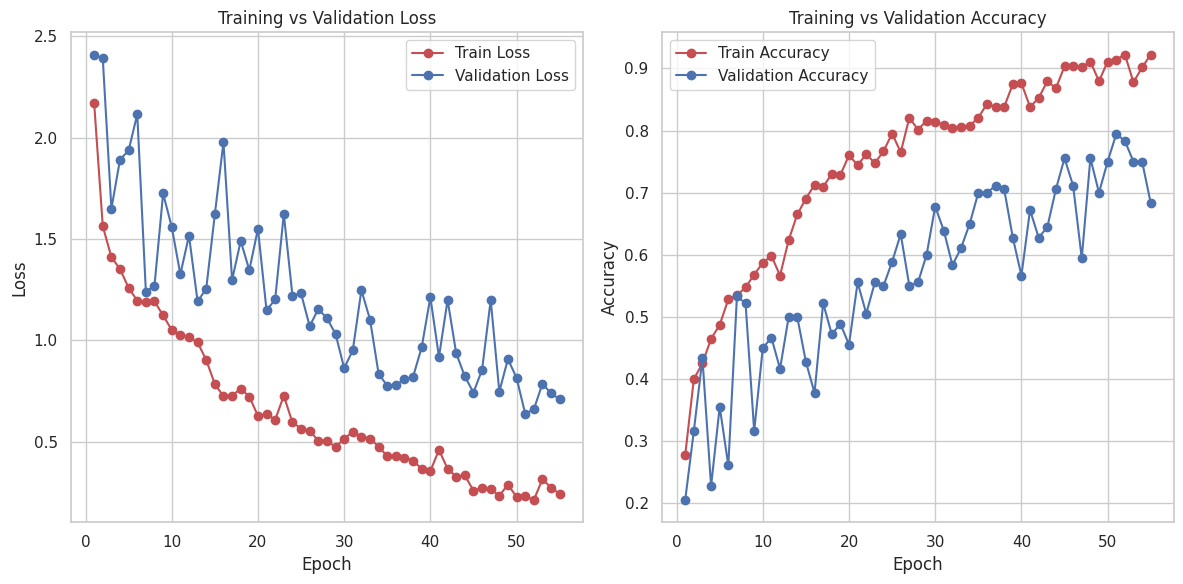

In [ ]:
net, history = train(net, train_loader, val_loader, test_loader, num_epochs=55, lr=0.001, patience=15)
plot_training_history()

The output shown in the image consists of two plots that track the training and validation performance of a model over 55 epochs. Here's a breakdown:

**Left Plot: Training vs. Validation Loss**
- *Train Loss (red)*: Gradually decreases over epochs, indicating that the model is learning the training data well.
- *Validation Loss (blue)*: Decreases initially but exhibits significant fluctuations, which may indicate difficulty in generalization. The validation loss does not decrease as smoothly as the training loss.

**Right Plot: Training vs. Validation Accuracy**
- *Train Accuracy (red)*: Steadily increases and approaches nearly 90%, showing that the model is successfully learning the training data.
- *Validation Accuracy (blue)*: Improves but is highly volatile, suggesting the model generalizes inconsistently.

**ResNet**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        # Shortcut connection to match dimensions if needed
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        # Pass input through the two convolutional layers
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        # Add the shortcut connection
        out += self.shortcut(x)
        # Apply ReLU activation to the result
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        # Initial convolutional layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        # ResNet layers composed of BasicBlocks
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        # Final classifier
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        # Create a ResNet layer by stacking `num_blocks` BasicBlocks
        layers = []
        # First block may change input/output dimensions
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        # Remaining blocks keep the same dimensions
        for _ in range(1, num_blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        # Forward pass through initial convolutional layer
        out = F.relu(self.bn1(self.conv1(x)))
        # Pass through each ResNet layer
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        # Perform global average pooling
        out = self.avg_pool(out)
        # Flatten for the fully connected layer
        out = out.view(out.size(0), -1)
        # Pass through the fully connected layer
        out = self.fc(out)
        return out

# Function to create a ResNet-18 as an example
def ResNet18(num_classes=10):
    # The number of blocks per layer for ResNet-18 is [2, 2, 2, 2]
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

# Example usage
model = ResNet18(num_classes=6)  # Adjust `num_classes` according to your dataset
print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

The code below defines a training pipeline for a ResNet-18 model using PyTorch. It begins by setting a fixed random seed for reproducibility across different libraries, ensuring consistent training behavior. The train_resnet function is responsible for training a ResNet model, handling both the training and validation phases while tracking performance metrics.

The Adam optimizer is used with a specified learning rate and weight decay for regularization, while cross-entropy loss is employed for classification tasks. During training, batches of data are processed iteratively, where the model performs forward passes, computes loss, and updates weights via backpropagation. A progress bar from the tqdm library provides real-time updates.

After each epoch, validation is performed without gradient updates, and validation loss and accuracy are computed. The model state is saved if the validation loss improves, ensuring that the best-performing model is preserved. The training history, containing epoch-wise loss and accuracy for both training and validation, is recorded and returned alongside the trained model. Finally, the script includes an example usage where a ResNet-18 model is instantiated and trained with predefined data loaders.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Define a training function similar to what you had before
def train_resnet(net, train_loader, val_loader, test_loader, num_epochs, lr, weight_decay=1e-4, device=None):
    """
    Train a ResNet model.
    """
    # If no device is specified, use GPU if available, otherwise CPU
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Send the model to the device
    net.to(device)

    # Define the optimizer and loss function
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.CrossEntropyLoss()

    # Track the best validation accuracy and loss
    best_val_loss = float('inf')
    best_val_acc = 0.0
    history = []  # To store epoch results

    for epoch in range(num_epochs):
        # Training phase
        net.train()
        train_loss, correct, total = 0.0, 0, 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for X, y in progress_bar:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = net(X)
            loss = loss_fn(y_hat, y)
            loss.backward()
            optimizer.step()

            # Update training metrics
            train_loss += loss.item() * X.size(0)
            correct += (y_hat.argmax(dim=1) == y).sum().item()
            total += X.size(0)
            progress_bar.set_postfix(loss=train_loss/total, acc=correct/total)

        # Validation phase
        net.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                y_hat = net(X)
                val_loss += loss_fn(y_hat, y).item() * X.size(0)
                val_correct += (y_hat.argmax(dim=1) == y).sum().item()
                val_total += X.size(0)
        val_loss /= val_total
        val_acc = val_correct / val_total

        # Print epoch results
        print(f"Epoch {epoch+1}: Train Loss={train_loss/total:.4f}, Train Acc={correct/total:.4f}, "
              f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

        # Track best validation metrics
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_acc = val_acc
            # Save the best model
            torch.save(net.state_dict(), 'best_resnet.pth')

        # Append to history
        history.append({
            'epoch': epoch + 1,
            'train_loss': train_loss / total,
            'train_acc': correct / total,
            'val_loss': val_loss,
            'val_acc': val_acc
        })

    # Save the final model
    torch.save(net.state_dict(), 'final_resnet.pth')
    print("Final model saved as 'final_resnet.pth'")

    return net, history

# Example usage
# Assume you have train_loader, val_loader, and test_loader already defined
# For example, if using your existing DataLoader setup, you can reuse those directly.
# And you can use the ResNet18 implementation defined earlier.
model = ResNet18(num_classes=6)
trained_model, training_history = train_resnet(model, train_loader, val_loader, test_loader, num_epochs=50, lr=0.001)


Epoch 1/50: 100%|██████████| 10/10 [00:33<00:00,  3.34s/it, acc=0.221, loss=2.31]


Epoch 1: Train Loss=2.3095, Train Acc=0.2206, Val Loss=7.8033, Val Acc=0.2000


Epoch 2/50: 100%|██████████| 10/10 [00:34<00:00,  3.45s/it, acc=0.349, loss=1.65]


Epoch 2: Train Loss=1.6502, Train Acc=0.3492, Val Loss=2.5309, Val Acc=0.2333


Epoch 3/50: 100%|██████████| 10/10 [00:33<00:00,  3.35s/it, acc=0.37, loss=1.53]


Epoch 3: Train Loss=1.5347, Train Acc=0.3698, Val Loss=1.6449, Val Acc=0.3278


Epoch 4/50: 100%|██████████| 10/10 [00:33<00:00,  3.38s/it, acc=0.394, loss=1.47]


Epoch 4: Train Loss=1.4691, Train Acc=0.3937, Val Loss=1.4688, Val Acc=0.4333


Epoch 5/50: 100%|██████████| 10/10 [00:34<00:00,  3.42s/it, acc=0.422, loss=1.44]


Epoch 5: Train Loss=1.4434, Train Acc=0.4222, Val Loss=1.3194, Val Acc=0.4500


Epoch 6/50: 100%|██████████| 10/10 [00:33<00:00,  3.36s/it, acc=0.429, loss=1.41]


Epoch 6: Train Loss=1.4068, Train Acc=0.4286, Val Loss=1.3798, Val Acc=0.4389


Epoch 7/50: 100%|██████████| 10/10 [00:33<00:00,  3.37s/it, acc=0.427, loss=1.37]


Epoch 7: Train Loss=1.3708, Train Acc=0.4270, Val Loss=1.2540, Val Acc=0.4722


Epoch 8/50: 100%|██████████| 10/10 [00:33<00:00,  3.36s/it, acc=0.44, loss=1.4]


Epoch 8: Train Loss=1.4038, Train Acc=0.4397, Val Loss=1.3560, Val Acc=0.4167


Epoch 9/50: 100%|██████████| 10/10 [00:34<00:00,  3.43s/it, acc=0.429, loss=1.38]


Epoch 9: Train Loss=1.3822, Train Acc=0.4286, Val Loss=1.4131, Val Acc=0.4722


Epoch 10/50: 100%|██████████| 10/10 [00:33<00:00,  3.37s/it, acc=0.471, loss=1.32]


Epoch 10: Train Loss=1.3222, Train Acc=0.4714, Val Loss=1.2642, Val Acc=0.5167


Epoch 11/50: 100%|██████████| 10/10 [00:33<00:00,  3.37s/it, acc=0.467, loss=1.35]


Epoch 11: Train Loss=1.3453, Train Acc=0.4667, Val Loss=1.2424, Val Acc=0.5278


Epoch 12/50: 100%|██████████| 10/10 [00:33<00:00,  3.37s/it, acc=0.451, loss=1.33]


Epoch 12: Train Loss=1.3292, Train Acc=0.4508, Val Loss=1.3417, Val Acc=0.4667


Epoch 13/50: 100%|██████████| 10/10 [00:34<00:00,  3.42s/it, acc=0.475, loss=1.34]


Epoch 13: Train Loss=1.3354, Train Acc=0.4746, Val Loss=1.2446, Val Acc=0.4944


Epoch 14/50: 100%|██████████| 10/10 [00:33<00:00,  3.40s/it, acc=0.438, loss=1.39]


Epoch 14: Train Loss=1.3933, Train Acc=0.4381, Val Loss=1.3373, Val Acc=0.4778


Epoch 15/50: 100%|██████████| 10/10 [00:33<00:00,  3.37s/it, acc=0.49, loss=1.31]


Epoch 15: Train Loss=1.3128, Train Acc=0.4905, Val Loss=1.3623, Val Acc=0.4778


Epoch 16/50: 100%|██████████| 10/10 [00:33<00:00,  3.37s/it, acc=0.494, loss=1.31]


Epoch 16: Train Loss=1.3089, Train Acc=0.4937, Val Loss=1.2313, Val Acc=0.4944


Epoch 17/50: 100%|██████████| 10/10 [00:33<00:00,  3.38s/it, acc=0.486, loss=1.3]


Epoch 17: Train Loss=1.3011, Train Acc=0.4857, Val Loss=1.3787, Val Acc=0.4167


Epoch 18/50: 100%|██████████| 10/10 [00:34<00:00,  3.44s/it, acc=0.473, loss=1.32]


Epoch 18: Train Loss=1.3155, Train Acc=0.4730, Val Loss=1.2563, Val Acc=0.4833


Epoch 19/50: 100%|██████████| 10/10 [00:33<00:00,  3.37s/it, acc=0.516, loss=1.27]


Epoch 19: Train Loss=1.2739, Train Acc=0.5159, Val Loss=1.1124, Val Acc=0.5889


Epoch 20/50: 100%|██████████| 10/10 [00:33<00:00,  3.38s/it, acc=0.508, loss=1.3]


Epoch 20: Train Loss=1.2970, Train Acc=0.5079, Val Loss=1.2522, Val Acc=0.4722


Epoch 21/50: 100%|██████████| 10/10 [00:33<00:00,  3.35s/it, acc=0.513, loss=1.24]


Epoch 21: Train Loss=1.2367, Train Acc=0.5127, Val Loss=1.2291, Val Acc=0.5611


Epoch 22/50: 100%|██████████| 10/10 [00:34<00:00,  3.43s/it, acc=0.532, loss=1.2]


Epoch 22: Train Loss=1.2028, Train Acc=0.5317, Val Loss=1.2446, Val Acc=0.5500


Epoch 23/50: 100%|██████████| 10/10 [00:33<00:00,  3.38s/it, acc=0.53, loss=1.26]


Epoch 23: Train Loss=1.2581, Train Acc=0.5302, Val Loss=1.2497, Val Acc=0.5222


Epoch 24/50: 100%|██████████| 10/10 [00:33<00:00,  3.37s/it, acc=0.506, loss=1.26]


Epoch 24: Train Loss=1.2604, Train Acc=0.5063, Val Loss=1.2748, Val Acc=0.4611


Epoch 25/50: 100%|██████████| 10/10 [00:33<00:00,  3.36s/it, acc=0.506, loss=1.24]


Epoch 25: Train Loss=1.2411, Train Acc=0.5063, Val Loss=1.2424, Val Acc=0.5222


Epoch 26/50: 100%|██████████| 10/10 [00:34<00:00,  3.41s/it, acc=0.502, loss=1.22]


Epoch 26: Train Loss=1.2199, Train Acc=0.5016, Val Loss=1.2954, Val Acc=0.4556


Epoch 27/50: 100%|██████████| 10/10 [00:34<00:00,  3.42s/it, acc=0.514, loss=1.26]


Epoch 27: Train Loss=1.2551, Train Acc=0.5143, Val Loss=1.3220, Val Acc=0.5167


Epoch 28/50: 100%|██████████| 10/10 [00:33<00:00,  3.36s/it, acc=0.524, loss=1.22]


Epoch 28: Train Loss=1.2235, Train Acc=0.5238, Val Loss=1.3896, Val Acc=0.4556


Epoch 29/50: 100%|██████████| 10/10 [00:33<00:00,  3.36s/it, acc=0.49, loss=1.3]


Epoch 29: Train Loss=1.2987, Train Acc=0.4905, Val Loss=1.1682, Val Acc=0.5056


Epoch 30/50: 100%|██████████| 10/10 [00:33<00:00,  3.37s/it, acc=0.527, loss=1.23]


Epoch 30: Train Loss=1.2290, Train Acc=0.5270, Val Loss=1.2654, Val Acc=0.5278


Epoch 31/50: 100%|██████████| 10/10 [00:34<00:00,  3.44s/it, acc=0.525, loss=1.16]


Epoch 31: Train Loss=1.1626, Train Acc=0.5254, Val Loss=1.2549, Val Acc=0.5167


Epoch 32/50: 100%|██████████| 10/10 [00:33<00:00,  3.37s/it, acc=0.543, loss=1.24]


Epoch 32: Train Loss=1.2361, Train Acc=0.5429, Val Loss=1.2073, Val Acc=0.5278


Epoch 33/50: 100%|██████████| 10/10 [00:33<00:00,  3.37s/it, acc=0.54, loss=1.16]


Epoch 33: Train Loss=1.1603, Train Acc=0.5397, Val Loss=1.2057, Val Acc=0.5056


Epoch 34/50: 100%|██████████| 10/10 [00:33<00:00,  3.38s/it, acc=0.562, loss=1.15]


Epoch 34: Train Loss=1.1549, Train Acc=0.5619, Val Loss=1.1434, Val Acc=0.5389


Epoch 35/50: 100%|██████████| 10/10 [00:34<00:00,  3.44s/it, acc=0.548, loss=1.15]


Epoch 35: Train Loss=1.1530, Train Acc=0.5476, Val Loss=1.2307, Val Acc=0.4778


Epoch 36/50: 100%|██████████| 10/10 [00:33<00:00,  3.38s/it, acc=0.576, loss=1.12]


Epoch 36: Train Loss=1.1232, Train Acc=0.5762, Val Loss=1.3015, Val Acc=0.5556


Epoch 37/50: 100%|██████████| 10/10 [00:33<00:00,  3.38s/it, acc=0.525, loss=1.19]


Epoch 37: Train Loss=1.1914, Train Acc=0.5254, Val Loss=1.2214, Val Acc=0.5000


Epoch 38/50: 100%|██████████| 10/10 [00:33<00:00,  3.37s/it, acc=0.563, loss=1.14]


Epoch 38: Train Loss=1.1431, Train Acc=0.5635, Val Loss=1.2082, Val Acc=0.5111


Epoch 39/50: 100%|██████████| 10/10 [00:34<00:00,  3.42s/it, acc=0.556, loss=1.15]


Epoch 39: Train Loss=1.1513, Train Acc=0.5556, Val Loss=1.1823, Val Acc=0.5111


Epoch 40/50: 100%|██████████| 10/10 [00:34<00:00,  3.42s/it, acc=0.57, loss=1.16]


Epoch 40: Train Loss=1.1577, Train Acc=0.5698, Val Loss=1.1292, Val Acc=0.5278


Epoch 41/50: 100%|██████████| 10/10 [00:33<00:00,  3.36s/it, acc=0.557, loss=1.12]


Epoch 41: Train Loss=1.1246, Train Acc=0.5571, Val Loss=1.1621, Val Acc=0.5278


Epoch 42/50: 100%|██████████| 10/10 [00:33<00:00,  3.37s/it, acc=0.567, loss=1.15]


Epoch 42: Train Loss=1.1543, Train Acc=0.5667, Val Loss=1.3112, Val Acc=0.4278


Epoch 43/50: 100%|██████████| 10/10 [00:33<00:00,  3.37s/it, acc=0.597, loss=1.1]


Epoch 43: Train Loss=1.0983, Train Acc=0.5968, Val Loss=1.1658, Val Acc=0.5611


Epoch 44/50: 100%|██████████| 10/10 [00:34<00:00,  3.42s/it, acc=0.606, loss=1.06]


Epoch 44: Train Loss=1.0571, Train Acc=0.6063, Val Loss=1.1303, Val Acc=0.5778


Epoch 45/50: 100%|██████████| 10/10 [00:33<00:00,  3.37s/it, acc=0.573, loss=1.13]


Epoch 45: Train Loss=1.1281, Train Acc=0.5730, Val Loss=1.2347, Val Acc=0.5278


Epoch 46/50: 100%|██████████| 10/10 [00:33<00:00,  3.37s/it, acc=0.562, loss=1.13]


Epoch 46: Train Loss=1.1315, Train Acc=0.5619, Val Loss=1.2612, Val Acc=0.5778


Epoch 47/50: 100%|██████████| 10/10 [00:33<00:00,  3.36s/it, acc=0.629, loss=1.09]


Epoch 47: Train Loss=1.0949, Train Acc=0.6286, Val Loss=1.0142, Val Acc=0.6000


Epoch 48/50: 100%|██████████| 10/10 [00:34<00:00,  3.44s/it, acc=0.568, loss=1.08]


Epoch 48: Train Loss=1.0759, Train Acc=0.5683, Val Loss=1.1713, Val Acc=0.5278


Epoch 49/50: 100%|██████████| 10/10 [00:33<00:00,  3.37s/it, acc=0.602, loss=1.09]


Epoch 49: Train Loss=1.0920, Train Acc=0.6016, Val Loss=1.2029, Val Acc=0.5278


Epoch 50/50: 100%|██████████| 10/10 [00:33<00:00,  3.37s/it, acc=0.611, loss=1.01]


Epoch 50: Train Loss=1.0144, Train Acc=0.6111, Val Loss=1.0121, Val Acc=0.6000
Final model saved as 'final_resnet.pth'


**Plot**

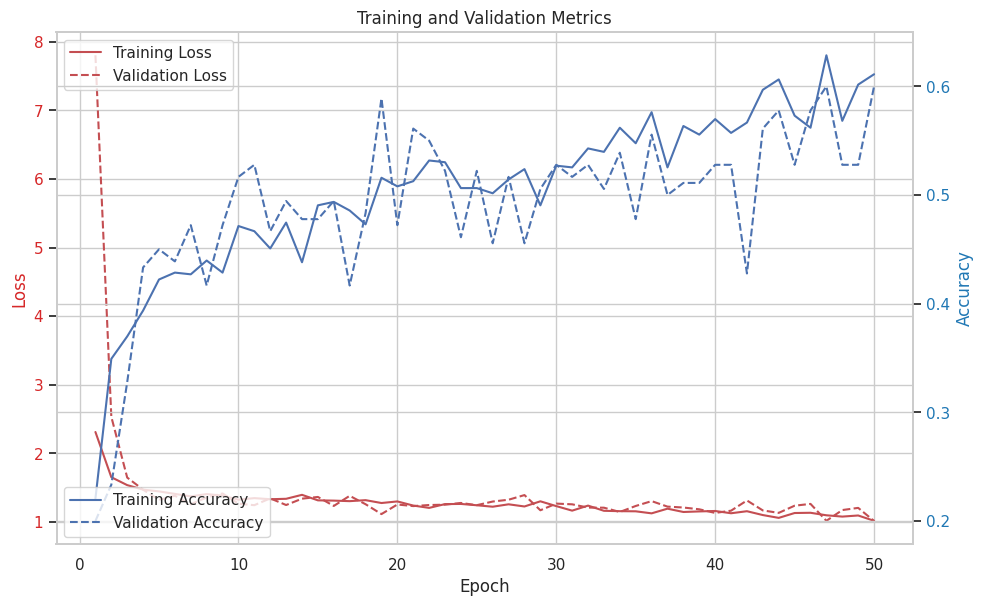

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plots training and validation loss and accuracy.
    The list `history` should contain dictionaries with the keys:
    'epoch', 'train_loss', 'train_acc', 'val_loss', 'val_acc'.
    """
    # Extract epochs and metrics from history
    epochs = [entry['epoch'] for entry in history]
    train_loss = [entry['train_loss'] for entry in history]
    val_loss = [entry['val_loss'] for entry in history]
    train_acc = [entry['train_acc'] for entry in history]
    val_acc = [entry['val_acc'] for entry in history]

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot loss on the left y-axis
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.plot(epochs, train_loss, 'r-', label='Training Loss')
    ax1.plot(epochs, val_loss, 'r--', label='Validation Loss')
    ax1.tick_params(axis='y', labelcolor='tab:red')
    ax1.legend(loc='upper left')

    # Create a twin y-axis for accuracy
    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy', color='tab:blue')
    ax2.plot(epochs, train_acc, 'b-', label='Training Accuracy')
    ax2.plot(epochs, val_acc, 'b--', label='Validation Accuracy')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    ax2.legend(loc='lower left')

    fig.tight_layout()
    plt.title("Training and Validation Metrics")
    plt.show()

# Call the function to display the plot
plot_training_history(training_history)


**Comparison of GoogleNet and ResNet-18 Training Performance**

Comparing GoogleNet and ResNet-18 reveals distinct performance differences in both loss and accuracy metrics.

**Loss:**  
- *GoogleNet* shows a clear decline in training loss, and although its validation loss experiences some fluctuations, it converges toward lower values overall.  
- *ResNet-18* maintains a very low and stable training loss; however, its validation loss remains consistently higher with less variation, indicating that it does not reach the lower loss values observed with GoogleNet.

**Accuracy:**  
- *GoogleNet* achieves high training accuracy and a validation accuracy that closely follows, reflecting better generalization to unseen data.  
- *ResNet-18*, while exhibitinggood training accuracy, has a lower validation accuracy, highlighting difficulties in transferring learned features from the training set to the validation set.

Overall, GoogleNet demonstrates more balanced and effective performance, as evidenced by its lower validation loss and higher validation accuracy compared to ResNet-18.